# Logistic Regression in R for Churn Modelling

I've been studying logistic regression, so I figured a good way to apply what I've learned is to use it to model employee churn with this dataset. 
I'm also trying to learn R, so I'll kill two birds with one stone by doing my analysis with an R notebook.

These youtube videos were very helpful throughout this process (in fact, the way I did my later plots is taken directly from a StatQuest video)

StatQuest's Logistic Regression Details Clearly Explained Series: https://youtu.be/vN5cNN2-HWE

StatQuest's Logistic Regression in R Clearly Explained: https://youtu.be/C4N3_XJJ-jU

Edureka's Logistic Regression in R tutorial: https://youtu.be/Z5WKQr4H4Xk

# Sizing up the situation

Let's create our DataFrame and see what our data looks like

In [86]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(caTools) #we'll use this library to split the dataset later for training/testing
library(cowplot)

theme_set(theme_cowplot())
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "churn-modelling"

In [87]:
df <- read.csv("../input/churn-modelling/Churn_Modelling.csv")

In [88]:
head(df)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,<int>,<int>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
6,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1


Looks pretty kosher, let's check out the structure of the DateFrame

In [89]:
str(df)

'data.frame':	10000 obs. of  14 variables:
 $ RowNumber      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ CustomerId     : int  15634602 15647311 15619304 15701354 15737888 15574012 15592531 15656148 15792365 15592389 ...
 $ Surname        : Factor w/ 2932 levels "Abazu","Abbie",..: 1116 1178 2041 290 1823 538 178 2001 1147 1082 ...
 $ CreditScore    : int  619 608 502 699 850 645 822 376 501 684 ...
 $ Geography      : Factor w/ 3 levels "France","Germany",..: 1 3 1 1 3 3 1 2 1 1 ...
 $ Gender         : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 2 2 1 2 2 ...
 $ Age            : int  42 41 42 39 43 44 50 29 44 27 ...
 $ Tenure         : int  2 1 8 1 2 8 7 4 4 2 ...
 $ Balance        : num  0 83808 159661 0 125511 ...
 $ NumOfProducts  : int  1 1 3 2 1 2 2 4 2 1 ...
 $ HasCrCard      : int  1 0 1 0 1 1 1 1 0 1 ...
 $ IsActiveMember : int  1 1 0 0 1 0 1 0 1 1 ...
 $ EstimatedSalary: num  101349 112543 113932 93827 79084 ...
 $ Exited         : int  1 0 1 0 0 1 0 1 0 0 ...


"HasCrCard", "IsActiveMember", and "Exited" are all currently int, but they are clearly meant to be categorical. We'll thus change them to factors

In [90]:
df$HasCrCard <- as.factor(df$HasCrCard)
df$IsActiveMember <- as.factor(df$IsActiveMember)
df$Exited <- as.factor(df$Exited)
str(df)

'data.frame':	10000 obs. of  14 variables:
 $ RowNumber      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ CustomerId     : int  15634602 15647311 15619304 15701354 15737888 15574012 15592531 15656148 15792365 15592389 ...
 $ Surname        : Factor w/ 2932 levels "Abazu","Abbie",..: 1116 1178 2041 290 1823 538 178 2001 1147 1082 ...
 $ CreditScore    : int  619 608 502 699 850 645 822 376 501 684 ...
 $ Geography      : Factor w/ 3 levels "France","Germany",..: 1 3 1 1 3 3 1 2 1 1 ...
 $ Gender         : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 2 2 1 2 2 ...
 $ Age            : int  42 41 42 39 43 44 50 29 44 27 ...
 $ Tenure         : int  2 1 8 1 2 8 7 4 4 2 ...
 $ Balance        : num  0 83808 159661 0 125511 ...
 $ NumOfProducts  : int  1 1 3 2 1 2 2 4 2 1 ...
 $ HasCrCard      : Factor w/ 2 levels "0","1": 2 1 2 1 2 2 2 2 1 2 ...
 $ IsActiveMember : Factor w/ 2 levels "0","1": 2 2 1 1 2 1 2 1 2 2 ...
 $ EstimatedSalary: num  101349 112543 113932 93827 79084 ...
 $ Exited         : Fact

# Making and Optimizing a Model

Our DataFrame structure looks good. Thankfully, the dataset is pretty clean and we likely will not need to worry about anything too weird in the columns. Eyes peeled though.

Now, we'll use glm to create a Generalized Linear Model from our DataFrame. The columns of RowNumber, CustomerID, and Surname will almost certainly have no effect on our regression, so we'll exclude them (although maybe Surname could provide insight into ethnicity or race, which may have an effect?)

In [91]:
model <- glm(Exited ~. - RowNumber - CustomerId - Surname, data = df, family = "binomial")
summary(model)


Call:
glm(formula = Exited ~ . - RowNumber - CustomerId - Surname, 
    family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3097  -0.6589  -0.4560  -0.2697   2.9940  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.392e+00  2.448e-01 -13.857  < 2e-16 ***
CreditScore      -6.683e-04  2.803e-04  -2.384   0.0171 *  
GeographyGermany  7.747e-01  6.767e-02  11.448  < 2e-16 ***
GeographySpain    3.522e-02  7.064e-02   0.499   0.6181    
GenderMale       -5.285e-01  5.449e-02  -9.699  < 2e-16 ***
Age               7.271e-02  2.576e-03  28.230  < 2e-16 ***
Tenure           -1.595e-02  9.355e-03  -1.705   0.0882 .  
Balance           2.637e-06  5.142e-07   5.128 2.92e-07 ***
NumOfProducts    -1.015e-01  4.713e-02  -2.154   0.0312 *  
HasCrCard1       -4.468e-02  5.934e-02  -0.753   0.4515    
IsActiveMember1  -1.075e+00  5.769e-02 -18.643  < 2e-16 ***
EstimatedSalary   4.807e-07  4.737e-07   1.015

glm outputs all of the coefficients for each of the independent variables we chose to include in our model. Check out the equation for binary logistic regression, pictured below.

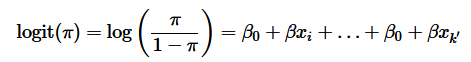

π is the probability that our binary dependent variable is 1 for the given independent variable(s) (in our case, the probability the employee will exit). The estimated coefficiencts correspond to the values of β.

glm also provides p-values and confidence ratings. For our analysis, a higher p-value is an indicator that that particular variable may not have a significant effect on the outcome. Furthermore, the star rating denotes the confidence rating that the variable will affect the regression. (*** = 99.9%, ** = 99%, * = 95%, . = 90%)

We can try to remove some of the variables with higher p-values, but we must also pay attention the deviance values. The Null Deviance and Residual Deviance describe how well the model predicts the response variable, or the "goodness of fit". Higher deviance denotes a worse fit. Null Deviance is the deviance value assuming only the intercept as a parameter, while Residual Deviance assumes all the parameters are used in the model. 

The AIC, or Akaike Information Criterion, similarly describes the "goodness of fit", and increases when unimportant variables are included in the model. 

So, we can use the p-values and confidence ratings as a guideline of what variables to exclude, but we must make sure their removal does not significantly increase the Residual Deviance or AIC.

Looking at the output, it appears that whether or not a person is from Germany has significant effect on the model. Beyond that, their specific country is not very consequential. We create another binary categorical column which tells of the person is from germany or not.

In [92]:
df$German <- ifelse(df$Geography == "Germany", "German", "NotGerman")


We then exclude the Geography column, and create a new model with the new column.

In [93]:
model <- glm(Exited ~. - RowNumber - CustomerId - Surname - Geography, data = df, family = "binomial")
summary(model)


Call:
glm(formula = Exited ~ . - RowNumber - CustomerId - Surname - 
    Geography, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3099  -0.6584  -0.4559  -0.2691   2.9901  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.620e+00  2.533e-01 -10.342  < 2e-16 ***
CreditScore     -6.666e-04  2.803e-04  -2.378   0.0174 *  
GenderMale      -5.283e-01  5.449e-02  -9.697  < 2e-16 ***
Age              7.272e-02  2.575e-03  28.238  < 2e-16 ***
Tenure          -1.598e-02  9.354e-03  -1.708   0.0876 .  
Balance          2.637e-06  5.142e-07   5.129 2.91e-07 ***
NumOfProducts   -1.013e-01  4.713e-02  -2.149   0.0316 *  
HasCrCard1      -4.493e-02  5.934e-02  -0.757   0.4489    
IsActiveMember1 -1.075e+00  5.768e-02 -18.640  < 2e-16 ***
EstimatedSalary  4.813e-07  4.736e-07   1.016   0.3095    
GermanNotGerman -7.629e-01  6.336e-02 -12.041  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*

Removing the overall geography and including the German column does not significantly change the Residual Deviance, and lowers the AIC by about 2. So, this is probably a good modification to the model.

By trial and error, it's found that removing the other high p-value/low confidence value variables has an adverse effect on the Residual Deviance. Thus, we'll keep them in the model.

# Visualizing the Model

We'll plot the results of the model in such a way that we can see the calculated probabilities, and the actual churn values. We'll create a DataFrame that has the exit probabilities, the actual exit value, and then order it by probability.

In [94]:
predicted.df <- data.frame(
    probability.of.exit = model$fitted.values,
    exit = df$Exited
)

In [95]:
predicted.df <- predicted.df[
    order(predicted.df$probability.of.exit,decreasing=FALSE),
]

predicted.df$rank <- 1:nrow(predicted.df)
head(predicted.df)

,probability.of.exit,exit,rank
,<dbl>,<fct>,<int>
3513,0.01134021,0,1
2142,0.01144211,1,2
3331,0.01145839,0,3
4717,0.01160433,0,4
7335,0.01191468,0,5
6888,0.01198471,0,6


Now we can create a plot of the exit probabilities with the dataframe columns. The actual exit value will be denoted by color.

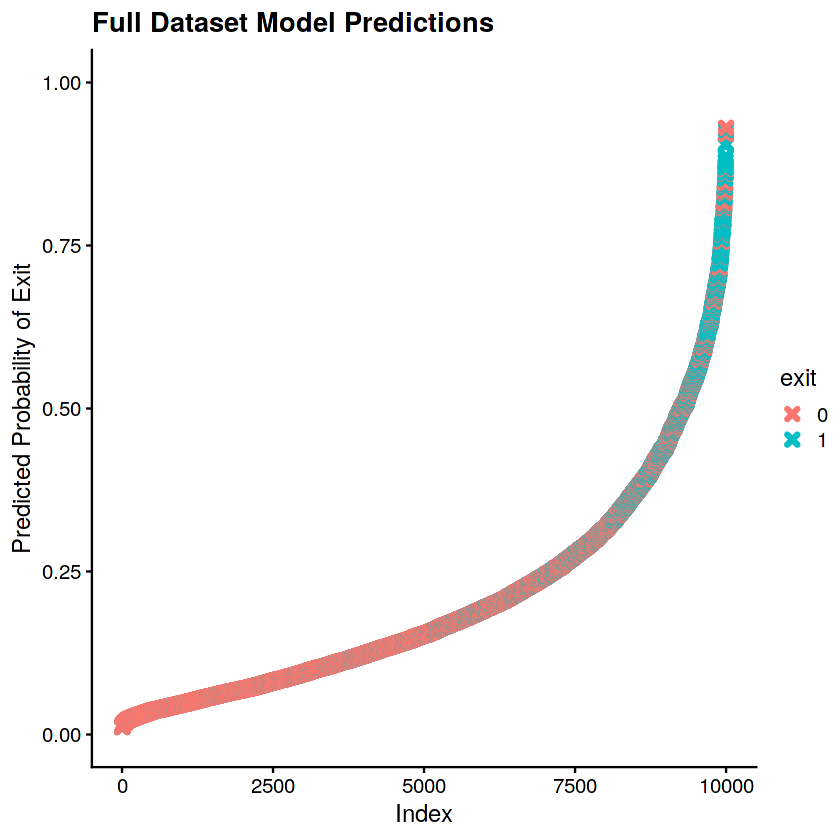

In [96]:
ggplot(data=predicted.df, aes(x=rank, y=probability.of.exit)) +
  geom_point(aes(color=exit), alpha = 1, shape = 4, stroke = 2) +
  ggtitle("Full Dataset Model Predictions") + 
  xlab("Index") +
  ylab("Predicted Probability of Exit") + 
  ylim(0,1)

It's a pretty cool visual! It looks like the model is quite good when it comes to predicting that employees will not exit, but less so when it comes to those that will exit.

A plot is cool, but it would also be nice to get numbers for accuracy, precision, etc. We're also concerned with overfitting the model to the dataframe: it's not clear how well the regression will predict churn for values not already within the model. Let's try doing a train-test split.

# Evaluation of the Model (Train-Test Split)

In a train-test split, we construct the model using only a portion of the DateFrame, commonly 80% of it. We then use the rest of the DataFrame as "out-of-set" values. We'll use the regression model to predict the probabilities of the of the testing split, and then compare them to the actual values. This way, we can determine whether our model is good for making predictions

In [97]:
split <- sample.split(df, SplitRatio = 0.8)
training <- subset(df, split == TRUE)
testing <- subset(df, split == FALSE)


We're going to set the Surname columns to NULL. We're not using it at all for our regression, so it's removal will not affect our quality of fit. The reason we are removing it from our training and testing DataFrames is that the split will cause the columns in each dataframe to have different levels, that is, they will have a different number of unique values. This will cause an error when using the predict function later, so we'll nip it in the bud now.

For our model, we'll use the same variables as we did in the full dataset model (I've checked that this gives the best deviance through trial and error as well)

In [98]:
training$Surname <- NULL
testing$Surname <- NULL
model2 <- glm(Exited ~. - RowNumber - CustomerId - Geography, data = training, family = "binomial")
summary(model2)


Call:
glm(formula = Exited ~ . - RowNumber - CustomerId - Geography, 
    family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2522  -0.6545  -0.4529  -0.2687   3.0005  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.602e+00  2.845e-01  -9.144  < 2e-16 ***
CreditScore     -5.001e-04  3.145e-04  -1.590   0.1118    
GenderMale      -5.016e-01  6.112e-02  -8.207 2.28e-16 ***
Age              7.221e-02  2.866e-03  25.190  < 2e-16 ***
Tenure          -1.888e-02  1.048e-02  -1.801   0.0716 .  
Balance          2.505e-06  5.770e-07   4.342 1.41e-05 ***
NumOfProducts   -1.586e-01  5.363e-02  -2.958   0.0031 ** 
HasCrCard1      -6.444e-02  6.642e-02  -0.970   0.3320    
IsActiveMember1 -1.109e+00  6.490e-02 -17.088  < 2e-16 ***
EstimatedSalary  5.729e-07  5.317e-07   1.078   0.2812    
GermanNotGerman -7.590e-01  7.110e-02 -10.675  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

Now, we can use the training model and the testing set in the predict function. The predict function will return the probabilities of exit for each of the objects in the dataframe. We'll say our threshold is a probability greater than or equal to 0.5 means the employee will exit, and will not exit for a probability less than 0.5

Given the predictions and the actual results, we can compare them in a confusion matrix, or a table that displays the prediction counts as aligned with the actual values.

In [99]:
res = predict(model2,testing,type="response")
cf_matrix = table(ActualValue=testing$Exited,PredictedValue=res>0.5)
cf_matrix

           PredictedValue
ActualValue FALSE TRUE
          0  1524   55
          1   342   80

The top row has the True Negative and the False Positive counts, from left to right.
The bottom row has the False Negative and the True Positive counts, from left to right.

As before, this model is pretty good at predicting non-exits, but not so good at predicting exits. It appears there are far fewer exits than non-exits in the dataframe, so the model didn't have a lot of exit data to learn from.

We'll use the info from the confusion matrix to calculate accuracy, precision, recall, the F1 scores for predicting exits and non-exits.

In [100]:
total <- sum(summary(testing$Exited)) 
TP <- cf_matrix[2,2]
TN <- cf_matrix[1,1]
FP <- cf_matrix[1,2]
FN <- cf_matrix[2,1]
PredictedYes <- TP+FP
PredictedNo <- TN+FN
ActualYes <- FN+TP
ActualNo <- TN+FP

OverallAccuracy <- (TP+TN) / total
MR <- 1-OverallAccuracy
TP_Rate <- TP/ActualYes
TN_Rate <- TN/ActualNo
Prevalence <- ActualYes/total

P0 <- TN / PredictedNo
P1 <- TP / PredictedYes

R0 <- TN / ActualNo
R1 <- TP / ActualYes

F1_0 <- 2*((P0*R0)/(P0+R0))
F1_1 <- 2*((P1*R1)/(P1+R1))

F1_avg <- ((F1_0*ActualNo)+(F1_1*ActualYes)) / total


The Overall Accuracy is simply the correct number of predictions over the total.

The F1 score is a metric of accuracy for the logistic regression model. It is the harmonic mean of precision (ratio of correct predictions to the number of predictions) and recall (ratio of correct predictions to number of samples that should have been predicted).

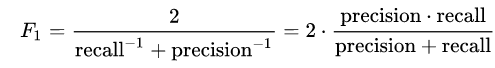

We'll display the values for these metrics in a bit. Let's make a plot for the testing set dataframe, like we did before

In [101]:
predicted.testing <- data.frame(
    probability.of.exit = res,
    exit = testing$Exited
)

In [102]:
predicted.testing <- predicted.testing[
    order(predicted.testing$probability.of.exit,decreasing=FALSE),
]

predicted.testing$rank <- 1:nrow(predicted.testing)

Okay, let's lay it all out for the world to see!

Precision(No Exit): 0.8167203 
Precision(Exit): 0.5925926 

Recall(No Exit): 0.9651678 
Recall(Exit): 0.1895735 

F1 Score(No Exit): 0.8847605 
F1 Score(Exit): 0.2872531 

Overall Accuracy: 0.8015992 
Weighted Average F1 Score: 0.7587495

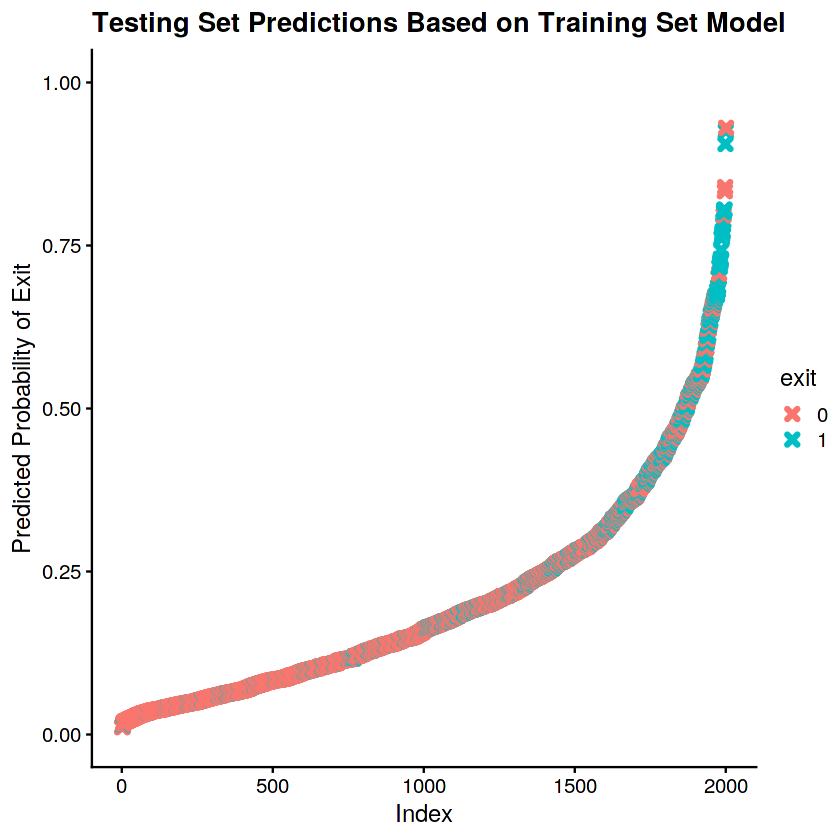

In [103]:
ggplot(data=predicted.testing, aes(x=rank, y=probability.of.exit)) +
  geom_point(aes(color=exit), alpha = 1, shape = 4, stroke = 2) +
  ggtitle("Testing Set Predictions Based on Training Set Model") + 
  xlab("Index") +
  ylab("Predicted Probability of Exit") + 
  ylim(0,1) 

cat("Precision(No Exit):",P0, "\n")
cat("Precision(Exit):",P1, "\n\n")

cat("Recall(No Exit):",R0, "\n")
cat("Recall(Exit):",R1, "\n\n")

cat("F1 Score(No Exit):",F1_0, "\n")
cat("F1 Score(Exit):",F1_1, "\n\n")

cat("Overall Accuracy:",OverallAccuracy,"\n")
cat("Weighted Average F1 Score:",F1_avg)

# Conclusion

Based on our accuracy metrics and plots, this seems like a half-decent model for employee churn. Having more exited employee objects to include in the model would help improve its ability to predict employee exits. I'd also like to use different analysis methods on this dataset: maybe a decision tree would yield better predictions?